In [1]:
import math
import numpy as np 
import scipy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import matplotlib 
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

In [3]:
plt.rcParams.update({'text.usetex': True,
                        'font.family': "sans-serif",
                        'text.latex.preamble': [r'\usepackage{amsmath}']})

## Neutral dynamics

In [ ]:
# defining the system of ODEs in the neutral limit and solving it: 

psis_rho = []
ts_rho = []

rhos = np.logspace(-4.5, 4.5, int(1e2))

for rho in rhos:
    def system(t, psi, rho):
        psi_0, psi_1x, psi_1y, psi_1z, psi_2xy, psi_2xz, psi_2yz, psi_3xyz = psi
    
        d_psi_0 = - rho*psi_0 - psi_0**2 + 2*rho/(1+t) # w/ psi0_0 = 2

        d_psi_1x = - rho*psi_1x - 2*psi_0*psi_1x + rho/(1+t)**2 # w/ psi0_1x = 0
        d_psi_1y = - rho*psi_1y - 2*psi_0*psi_1y + rho/(1+t)**2 # w/ psi0_1y = 0
        d_psi_1z = - rho*psi_1z - 2*psi_0*psi_1z # w/ psi0_1z = 1

        d_psi_2xy = - rho*psi_2xy - 2*psi_0*psi_2xy - 4*psi_1x*psi_1y # w/ psi0_2xy = 0
        d_psi_2xz = - rho*psi_2xz - 2*psi_0*psi_2xz - 4*psi_1x*psi_1z # w/ psi0_2xz = 0
        d_psi_2yz = - rho*psi_2yz - 2*psi_0*psi_2yz - 4*psi_1y*psi_1z # w/ psi0_2yz = 0

        d_psi_3xyz = - rho*psi_3xyz - 2*psi_0*psi_3xyz - 6*psi_1x*psi_2yz - 6*psi_1y*psi_2xz - 6*psi_1z*psi_2xy  # w/ psi0_3xyz = 0
    
        return d_psi_0, d_psi_1x, d_psi_1y, d_psi_1z, d_psi_2xy, d_psi_2xz, d_psi_2yz, d_psi_3xyz
    
    psi0 = [2, 0, 0, 1, 0, 0, 0, 0] # initial conditions
    
    t_start = 0; t_stop = 3 / rho # start and stop times for integration
    
    soln = solve_ivp(system, [t_start, t_stop], psi0, args=[rho], dense_output=True) # solving the equations! 
    
    ts = np.linspace(t_start, t_stop, int(1e6)) # times to evaluate solution at
    interp = soln.sol(ts)
    psis_rho.append(interp)
    ts_rho.append(ts)
    

In [ ]:
# defining the integrand:

def integrand_neutral(rho, t, psi_1z_t, psi_2xz_t, psi_2yz_t, psi_3xyz_t):
    return rho*psi_1z_t - 1/2*(1+rho*(1+t))*(psi_2xz_t+psi_2yz_t) + 1/6*(1+t)*(2-rho*(1+t))*psi_3xyz_t

In [ ]:
# calculating the integrand:

fs_rho = []
for i in range(len(rhos)):
    fs_rho.append([integrand_neutral(rhos[i], ts_rho[i][j], 
                             psis_rho[i][3][j], # psi_1z_t
                             psis_rho[i][5][j], # psi_2xz_t
                             psis_rho[i][6][j], # psi_2yz_t
                             psis_rho[i][7][j]) # psi_3xyz_t
                   for j in range(len(ts_rho[i]))])

In [ ]:
# integrating the integrand:

lambda_rho_neutral = {}
for i in range(len(rhos)):
    l = 0
    for j in range(len(ts_rho[i]) - 1):
        l += (ts_rho[i][j + 1] - ts_rho[i][j]) * fs_rho[i][j]
    lambda_rho_neutral[rhos[i]] = l

In [5]:
# saving numerical results:

'''
with open('lambda_rho_neutral.txt', 'w+') as o:
    o.writelines(['rho\tlambda\n'] + [str(x) + '\t' + str(y) + '\n' for x, y in zip(rhos, [lambda_rho_neutral[x] for x in rhos])])
'''

# downloading numerical results:

with open('lambda_rho_neutral.txt') as f:
    lambda_rho_neutral = dict([list(map(float, x.split())) for x in f.readlines()[1:]])

In [6]:
# downloading simulation results:

with open('../simulations/LE_r_nruns=1e9_points.txt') as f:
    neutral_simulated = [list(map(float, x.split())) for x in f.readlines()] # f*, x (lambda), y (rho)

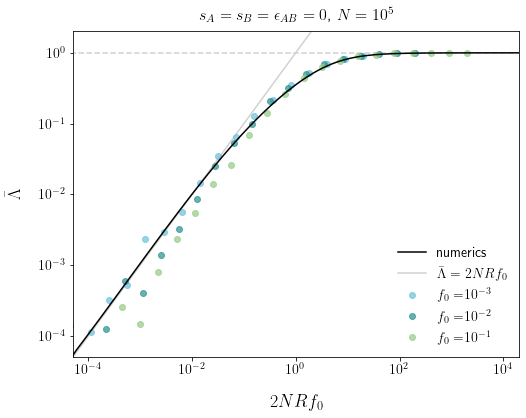

In [7]:
# comparing simulations w/ numerics:

plt.figure(figsize=(8,6))

colors = ['#6DC1DB', '#299191', '#95CB88']
grey = '#d1d1d1'

N = 1e5
fs = [0.001, 0.01, 0.1]
rhos = np.logspace(-4.5, 4.5, int(1e2))

plt.plot(rhos, [lambda_rho_neutral[x] for x in rhos], color='black', label='numerics', zorder=5)

plt.loglog(np.logspace(-6.5,5,25), np.ones_like(np.logspace(-6.5,5,25)), '--', color=grey)
plt.loglog(np.logspace(-6.5,5,25), np.logspace(-6.5,5,25), color=grey, label="$\\bar{\\Lambda} = 2NRf_0$")

c = 0
for f in fs:
    
    plt.loglog([x[1] for x in neutral_simulated if x[0] == f], [x[2] for x in neutral_simulated if x[0] == f], 'o', 
               color=colors[c], alpha=0.7, 
               label='$f_0=$' + "$10^{" + '{:0.0f}'.format(math.log10(f)) + "}$")
    c += 1

plt.xticks([1e-4, 1e-2, 1e0, 1e2, 1e4], 
           ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$'])
plt.yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0], 
           ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
plt.ylim([5e-5, 2])
plt.xlim([5e-5, 2e4])

plt.minorticks_off()
plt.tick_params(axis='both', labelsize=14)

plt.ylabel("$\\bar{\\Lambda}$", fontsize=18, labelpad=16)
plt.xlabel("$2 N R f_0$", fontsize=18, labelpad=18)    
plt.title("$s_A = s_B = \\epsilon_{AB} = 0$" + ", " + "$N = 10^5$", fontsize=16, pad=12)

plt.legend(frameon=False,fontsize=14,loc='lower right');

# plt.savefig('neutral_lambda_numerics.png', dpi=300, bbox_inches='tight')


## Dynamics under selection

### Weak recombination

In [ ]:
# under weak recombination, we only need to add selection to the ODEs:

psis_rho = []

sel_a = 10; sel_b = 10; eps = 0; sel_ab = sel_a + sel_b + eps # gammas
rhos_1 = np.logspace(-3, math.log(sel_ab, 10), int(1e2))

for rho in rhos_1:
    def system(t, psi, rho, gamma_a, gamma_b, gamma_ab): # gamma_ab = gamma_a + gamma_b + gamma_e
        psi_0, psi_1x, psi_1y, psi_1z, psi_2xy, psi_2xz, psi_2yz, psi_3xyz = psi
    
        d_psi_0 = (- (rho+gamma_ab)*psi_0 - psi_0**2 
                   + rho*gamma_a*math.exp(-gamma_a*t)/(1+gamma_a-math.exp(-gamma_a*t)) 
                   + rho*gamma_b*math.exp(-gamma_b*t)/(1+gamma_b-math.exp(-gamma_b*t))) # w/ psi0_0 = 2

        d_psi_1x = (- (rho+gamma_ab)*psi_1x - 2*psi_0*psi_1x 
                    + rho*(gamma_a**2)*math.exp(-gamma_a*t)/(1+gamma_a-math.exp(-gamma_a*t))**2) # w/ psi0_1x = 0
        
        d_psi_1y = (- (rho+gamma_ab)*psi_1y - 2*psi_0*psi_1y
                    + rho*(gamma_b**2)*math.exp(-gamma_b*t)/(1+gamma_b-math.exp(-gamma_b*t))**2) # w/ psi0_1y = 0
        
        d_psi_1z = - (rho+gamma_ab)*psi_1z - 2*psi_0*psi_1z # w/ psi0_1z = 1

        d_psi_2xy = - (rho+gamma_ab)*psi_2xy - 2*psi_0*psi_2xy - 4*psi_1x*psi_1y # w/ psi0_2xy = 0
        d_psi_2xz = - (rho+gamma_ab)*psi_2xz - 2*psi_0*psi_2xz - 4*psi_1x*psi_1z # w/ psi0_2xz = 0
        d_psi_2yz = - (rho+gamma_ab)*psi_2yz - 2*psi_0*psi_2yz - 4*psi_1y*psi_1z # w/ psi0_2yz = 0

        d_psi_3xyz = - (rho+gamma_ab)*psi_3xyz - 2*psi_0*psi_3xyz - 6*psi_1x*psi_2yz - 6*psi_1y*psi_2xz - 6*psi_1z*psi_2xy  # w/ psi0_3xyz = 0
    
        return d_psi_0, d_psi_1x, d_psi_1y, d_psi_1z, d_psi_2xy, d_psi_2xz, d_psi_2yz, d_psi_3xyz
    
    psi0 = [2, 0, 0, 1, 0, 0, 0, 0] # initial conditions

    
    t_start = 0; t_stop = 1
    soln = solve_ivp(system, [t_start, t_stop], psi0, args=[rho, sel_a, sel_b, sel_ab], dense_output=True) # solving the equations! 
    
    # times to evaluate solution at 
    ts = np.linspace(t_start, t_stop, int(1e4))

    interp = soln.sol(ts)
    psis_rho.append(interp)
    

In [ ]:
# defining the integrand: 

def integrand_sel(rho, t, psi_1z_t, psi_2xz_t, psi_2yz_t, psi_3xyz_t, gamma_a, gamma_b, gamma_ab):
    
    phi_0x_t = - (1+gamma_a-math.exp(-gamma_a*t))/(gamma_a*(1+gamma_a))
    phi_0y_t = - (1+gamma_b-math.exp(-gamma_b*t))/(gamma_b*(1+gamma_b))
    
    phi_1x_t = math.exp(-gamma_a*t)/(1+gamma_a)**2
    phi_1y_t = math.exp(-gamma_b*t)/(1+gamma_b)**2

    return ((1+sel_a)*(1+sel_b))**2 * (rho*psi_1z_t*phi_1x_t*phi_1y_t - 1/2*psi_2xz_t*phi_1y_t*(1-rho*phi_0x_t) - 1/2*psi_2yz_t*phi_1x_t*(1-rho*phi_0y_t) + 1/6*psi_3xyz_t*(phi_0x_t+phi_0y_t-rho*phi_0x_t*phi_0y_t))



In [ ]:
# calculating the integrand: 

fs_rho = []
for i in range(len(rhos_1)):
             
    fs_rho.append([integrand_sel(rhos_1[i], ts[j], 
                       psis_rho[i][3][j], # psi_1z_t
                       psis_rho[i][5][j], # psi_2xz_t
                       psis_rho[i][6][j], # psi_2yz_t
                       psis_rho[i][7][j],
                       sel_a, sel_b, sel_ab) # psi_3xyz_t
                   for j in range(len(ts))])

In [ ]:
# integrating the integrand:

lambda_rho_sel = {}
for i in range(len(rhos_1)):
    
    l = 0
    for j in range(len(ts) - 1):
        l += (ts[j + 1] - ts[j]) * fs_rho[i][j]
    lambda_rho_sel[rhos_1[i]] = l
    

In [8]:
# saving numerical results:

'''
with open('lambda_rho_selAB=1e3_small_r.txt', 'w+') as o:
    o.writelines(['rho\tlambda\n'] + [str(x) + '\t' + str(y) + '\n' for x, y in zip(rhos_1, [lambda_rho_sel[x] for x in rhos_1])])
'''

# downloading numerical results:

with open('lambda_rho_selAB=1e3_small_r.txt') as f:
    lambda_rho_sel = dict([list(map(float, x.split())) for x in f.readlines()[1:]])

### Strong recombination

In [ ]:
# under strong recombination, need to rescale the time to capture the fast recombination dynamics:

psis_rho = []

sel_a = 10; sel_b = 10; eps = 0; sel_ab = sel_a + sel_b + eps # gammas
rhos_2 = np.logspace(math.log(sel_ab, 10), math.log(2e5), 50)

for rho in rhos_2:
    def system(u, psi, rho, gamma_a, gamma_b, gamma_ab): # gamma_ab = gamma_a + gamma_b + gamma_e
        psi_0, psi_1x, psi_1y, psi_1z, psi_2xy, psi_2xz, psi_2yz, psi_3xyz = psi
    
        d_psi_0 = (- (1+gamma_ab/rho)*psi_0 - 1/rho*psi_0**2 
                   + gamma_a*math.exp(-gamma_a/rho*u)/(1+gamma_a-math.exp(-gamma_a/rho*u)) 
                   + gamma_b*math.exp(-gamma_b/rho*u)/(1+gamma_b-math.exp(-gamma_b/rho*u))) # w/ psi0_0 = 2

        d_psi_1x = (- (1+gamma_ab/rho)*psi_1x - 2/rho*psi_0*psi_1x 
                    + (gamma_a**2)*math.exp(-gamma_a/rho*u)/(1+gamma_a-math.exp(-gamma_a/rho*u))**2) # w/ psi0_1x = 0
        
        d_psi_1y = (- (1+gamma_ab/rho)*psi_1y - 2/rho*psi_0*psi_1y 
                    + (gamma_b**2)*math.exp(-gamma_b/rho*u)/(1+gamma_b-math.exp(-gamma_b/rho*u))**2) # w/ psi0_1y = 0
        
        d_psi_1z = - (1+gamma_ab/rho)*psi_1z - 2/rho*psi_0*psi_1z # w/ psi0_1z = 1

        d_psi_2xy = - (1+gamma_ab/rho)*psi_2xy - 2/rho*psi_0*psi_2xy - 4/rho*psi_1x*psi_1y # w/ psi0_2xy = 0
        d_psi_2xz = - (1+gamma_ab/rho)*psi_2xz - 2/rho*psi_0*psi_2xz - 4/rho*psi_1x*psi_1z # w/ psi0_2xz = 0
        d_psi_2yz = - (1+gamma_ab/rho)*psi_2yz - 2/rho*psi_0*psi_2yz - 4/rho*psi_1y*psi_1z # w/ psi0_2yz = 0

        d_psi_3xyz = - (1+gamma_ab/rho)*psi_3xyz - 2/rho*psi_0*psi_3xyz - 6/rho*psi_1x*psi_2yz - 6/rho*psi_1y*psi_2xz - 6/rho*psi_1z*psi_2xy  # w/ psi0_3xyz = 0
    
        return d_psi_0, d_psi_1x, d_psi_1y, d_psi_1z, d_psi_2xy, d_psi_2xz, d_psi_2yz, d_psi_3xyz
    
    psi0 = [2, 0, 0, 1, 0, 0, 0, 0] # initial conditions
    
    u_start = 0; u_stop = 1e3 # start and stop times for integration
    
    soln = solve_ivp(system, [u_start, u_stop], psi0, args=[rho, sel_a, sel_b, sel_ab], dense_output=True) # solving the equations! 
    
    us = np.linspace(u_start, u_stop, int(1e5)) # times to evaluate solution at
    interp = soln.sol(us)
    psis_rho.append(interp)

In [ ]:
# defining the integrand:

def integrand_sel_r(rho, u, psi_1z_t, psi_2xz_t, psi_2yz_t, psi_3xyz_t, gamma_a, gamma_b, gamma_ab):
    
    phi_0x_t = - (1+gamma_a-math.exp(-gamma_a/rho*u))/(gamma_a*(1+gamma_a))
    phi_0y_t = - (1+gamma_b-math.exp(-gamma_b/rho*u))/(gamma_b*(1+gamma_b))
    
    phi_1x_t = math.exp(-gamma_a/rho*u)/(1+gamma_a)**2
    phi_1y_t = math.exp(-gamma_b/rho*u)/(1+gamma_b)**2


    return ((1+sel_a)*(1+sel_b))**2 * (psi_1z_t*phi_1x_t*phi_1y_t - 1/2/rho*psi_2xz_t*phi_1y_t*(1-rho*phi_0x_t) - 1/2/rho*psi_2yz_t*phi_1x_t*(1-rho*phi_0y_t) + 1/6/rho*psi_3xyz_t*(phi_0x_t+phi_0y_t-rho*phi_0x_t*phi_0y_t))


In [ ]:
# calculating the integrand:

fs_rho = []
for i in range(len(rhos_2)):
    fs_rho.append([integrand_sel_r(rhos_2[i], us[j], 
                       psis_rho[i][3][j], # psi_1z_t
                       psis_rho[i][5][j], # psi_2xz_t
                       psis_rho[i][6][j], # psi_2yz_t
                       psis_rho[i][7][j],
                       sel_a, sel_b, sel_ab) # psi_3xyz_t
                   for j in range(len(us))])

In [ ]:
# integrating the integrand:

lambda_rho_sel_r = {}
for i in range(len(rhos_2)):
    l = 0
    for j in range(len(us) - 1):
        l += (us[j + 1] - us[j]) * fs_rho[i][j]
    lambda_rho_sel_r[rhos_2[i]] = l

In [9]:
# saving numerical results:

'''
with open('lambda_rho_selAB=1e3_large_r.txt', 'w+') as o:
    o.writelines(['rho\tlambda\n'] + [str(x) + '\t' + str(y) + '\n' for x, y in zip(rhos_2, [lambda_rho_sel_r[x] for x in rhos_2])])
'''

# downloading numerical results:

with open('lambda_rho_selAB=1e3_large_r.txt') as f:
    lambda_rho_sel_r = dict([list(map(float, x.split())) for x in f.readlines()[1:]])

In [10]:
# downloading simulation results: 

N = 1e6
s = 1e-3

path = '/Users/alyulina/Projects/Linkage equilibrium/figures/'
regime = 'r_selAB=1e-3'

points = {}    
points[regime] = {}
points[regime]['fs'] = np.load(path + '%s_fstars.npy' % regime)
points[regime]['rs'] = np.load(path + '%s_rs.npy' % regime)
points[regime]['nums'] = np.load(path + '%s_numers.npy' % regime)
points[regime]['denoms'] = np.load(path + '%s_denoms.npy' % regime)
    

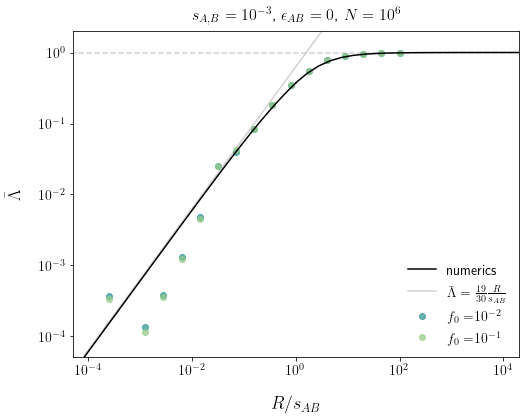

In [15]:
# comparing simulations w/ numerics:

sel_a = 10; sel_b = 10; eps = 0; sel_ab = sel_a + sel_b + eps
rhos_1 = np.logspace(-3, math.log(sel_ab, 10), int(1e2))
rhos_2 = np.logspace(math.log(sel_ab, 10), math.log(2e5), 50)

plt.figure(figsize=(8,6))

colors = ['#299191', '#95CB88']
grey = '#d1d1d1' 

plt.plot([x / sel_ab for x in rhos_1], [lambda_rho_sel[x] for x in rhos_1], color='black', label='numerics', zorder=5)
plt.plot([x / sel_ab for x in rhos_2], [lambda_rho_sel_r[x] for x in rhos_2], color='black', zorder=6)
plt.loglog(np.logspace(-6.5,5,25), np.ones_like(np.logspace(-6.5,5,25)), '--', color=grey)

for j, f in enumerate(points['r_selAB=1e-3']['fs']):

    if f not in [0.01, 0.1]:
        continue
        
    xs = []
    ys = []
        
    for i, r in enumerate(points[regime]['rs']):     
        xs.append(r / s)
        ys.append(points[regime]['nums'][i, j] / points[regime]['denoms'][i, j])
        
    if j == 22: 
        plt.loglog(xs, [x * 19 / 60 * 2 for x in xs], color=grey, label="$\\bar{\\Lambda} = \\frac{19}{30}\\frac{R}{s_{AB}}$")

    if j == len(points['r_selAB=1e-3']['fs']) - 1: 
        color = colors[-1]
    else:
        color = colors[0]
        
    plt.loglog(xs, ys, 'o', color=color, alpha=0.7,  label='$f_0=$' + "$10^{" + '{:0.0f}'.format(math.log10(f)) + "}$")
    
    
plt.xticks([1e-4, 1e-2, 1e0, 1e2, 1e4], 
           ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$'])
plt.yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0], 
           ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
plt.ylim([5e-5, 2])
plt.xlim([5e-5, 2e4])

plt.minorticks_off()
plt.tick_params(axis='both', labelsize=14)

plt.ylabel("$\\bar{\\Lambda}$", fontsize=18, labelpad=16)
plt.xlabel("$R / s_{AB}$", fontsize=18, labelpad=18)    
plt.title("$s_{A,B} = 10^{-3}$" + ", " + "$\epsilon_{AB} = 0$" + ", " + "$N = 10^6$", fontsize=16, pad=12)

plt.legend(frameon=False,fontsize=14,loc='lower right');

# plt.savefig('selection_fig_sAB=1e-3_r_s.png',dpi=600,bbox_inches='tight') 
